## Use **Fuzzing Book** Resources

Clone the [Fuzzing Book](https://www.fuzzingbook.org/) repository and put this notebook under the directory `fuzzingbook/notebooks/`. Then you can use the fuzzing book resources in this notebook.

In [1]:
import sys
sys.path.append("notebooks/") # add the notebooks directory to the path

import bookutils
from typing import List, Tuple, Dict, Any
from Fuzzer import RandomFuzzer
from html.parser import HTMLParser
from Coverage import Coverage
import pickle
import hashlib
from tqdm import tqdm

# **0. Preparation**

## Choose the target SUT & Initialize the fuzzer

### A program-under-test: HTML parser

In [2]:
def my_parser(inp: str) -> None:
    parser = HTMLParser()
    parser.feed(inp)

# Getting the coverage given the input
inp = "<html>"

with Coverage() as cov:
    my_parser(inp)
cov.coverage()

{('__init__', 28),
 ('__init__', 92),
 ('__init__', 93),
 ('__init__', 94),
 ('check_for_whole_start_tag', 346),
 ('check_for_whole_start_tag', 347),
 ('check_for_whole_start_tag', 348),
 ('check_for_whole_start_tag', 349),
 ('check_for_whole_start_tag', 350),
 ('check_for_whole_start_tag', 351),
 ('check_for_whole_start_tag', 352),
 ('feed', 110),
 ('feed', 111),
 ('goahead', 135),
 ('goahead', 136),
 ('goahead', 137),
 ('goahead', 138),
 ('goahead', 139),
 ('goahead', 140),
 ('goahead', 141),
 ('goahead', 161),
 ('goahead', 166),
 ('goahead', 167),
 ('goahead', 168),
 ('goahead', 169),
 ('goahead', 170),
 ('goahead', 171),
 ('goahead', 185),
 ('goahead', 199),
 ('goahead', 245),
 ('goahead', 251),
 ('handle_starttag', 425),
 ('my_parser', 2),
 ('my_parser', 3),
 ('parse_starttag', 302),
 ('parse_starttag', 303),
 ('parse_starttag', 304),
 ('parse_starttag', 306),
 ('parse_starttag', 307),
 ('parse_starttag', 310),
 ('parse_starttag', 311),
 ('parse_starttag', 312),
 ('parse_starttag'

### Create simple fuzzer: random string generator

In [6]:
fuzzer = RandomFuzzer(
    min_length=1, max_length=100, char_start=32, char_range=94
)
print("input 1:", fuzzer.fuzz())
print("input 2:", fuzzer.fuzz())
print("input 3:", fuzzer.fuzz())

input 1: .tSxI_NRx -9C*I
input 2: 6F-,V29vR}f w#sTy?_5\r!vzzo9Hz7j"jvN&yZE0nv(83(o2L{H]pn5)9i5i')LVI(E4z
input 3: nYX8EyapEh37Lbwb:]vHW.-0RK19eDGfj?%


### Ease of use: Coverage $\rightarrow$ Hexstring (hashing) (:= a color of a ball)

In [13]:
hashlib.md5(b"exampl").hexdigest()

'98bf5cdb0b35f833ef85e1322bf1457a'

In [7]:
# Coverage -> hexstring (a colored ball)
def getCovHash(cov: Coverage) -> str:
    pickledCov = pickle.dumps(cov.coverage())
    hashedCov = hashlib.md5(pickledCov).hexdigest()
    return hashedCov

covlist = list(cov.coverage())
print(
f"The coverage [{covlist[0]}\n"
f"              {covlist[1]}\n"
f"              {covlist[2]}\n"
f"              {covlist[3]}\n"
f"              {covlist[4]}\n"
f"              ...]")
print(f"is converted to the color {getCovHash(cov)}.")

The coverage [('goahead', 199)
              ('goahead', 141)
              ('reset', 101)
              ('check_for_whole_start_tag', 349)
              ('parse_starttag', 304)
              ...]
is converted to the color 574cb3ff1a3132f76aab7d45b4afca2d.


### **The rarity differs for different coverage (color)**

#### First 10 samples (= coverage from execution)

In [16]:
# n: number of samples
n = 10
print(f"{n} samples from the urn:")
for i in tqdm(range(n)):
    inp = fuzzer.fuzz()
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    print(f"| sample {i + 1:2d}th: {getCovHash(cov)}")

10 samples from the urn:


100%|██████████| 10/10 [00:00<00:00, 3325.38it/s]

| sample  1th: bc37ac268cb06873eb9e0a6a24c4ffb8
| sample  2th: 15d5b61af383646cc0edd1ca587f7ea5
| sample  3th: cea00122997440c83ea6e35ae218ea90
| sample  4th: 1e0c25c55de274b4e90133e55354146d
| sample  5th: cea00122997440c83ea6e35ae218ea90
| sample  6th: cea00122997440c83ea6e35ae218ea90
| sample  7th: 96b70cb7e488a982907f32a53fbb0423
| sample  8th: 96b70cb7e488a982907f32a53fbb0423
| sample  9th: 96b70cb7e488a982907f32a53fbb0423
| sample 10th: 96b70cb7e488a982907f32a53fbb0423


#### Distribution of frequencies of colors (n = 10,000)

In [17]:
# n: number of samples
n = 10000

# Population of inputs
population = []
for i in range(n):
    population.append(fuzzer.fuzz())

############# Record the frequency of each coverage #############
# all_coverage_dict: coverage hash -> frequency
#################################################################
all_coverage_dict = {}
for inp in tqdm(population):
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    covhex = getCovHash(cov)
    if covhex not in all_coverage_dict:
        all_coverage_dict[covhex] = 0
    all_coverage_dict[covhex] += 1
#################################################################

100%|██████████| 10000/10000 [00:01<00:00, 8363.92it/s]


Number of unique color: 219
Top 3 frequencies: [4036, 1079, 1072]
Bottom 3 frequencies: [1, 1, 1]


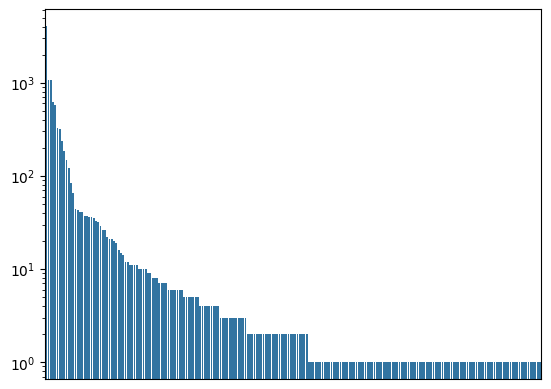

In [18]:
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

num_unique = len(all_coverage_dict)
print(f"Number of unique color: {num_unique}")
print(
    f"Top 3 frequencies: {sorted(list(all_coverage_dict.values()), reverse=True)[:3]}"
)
print(f"Bottom 3 frequencies: {sorted(list(all_coverage_dict.values()))[:3]}")
freqs = sorted(list(all_coverage_dict.values()), reverse=True)
# print bar chart of the frequencies
fig, ax = plt.subplots()
sns.barplot(x=list(range(len(freqs))), y=freqs, ax=ax)
# remove the x labels
ax.set_xticks([])
# set log-scale for y-axis
ax.set_yscale("log")
plt.show()

## Some Definitions

- Singletons: colors that appear only once in the sample
- Doubletons: colors that appear twice in the sample

$$
\Phi_k = \text{the number of colors that appear $k$ times in the sample}
$$

- $\Phi_1$ = the number of singletons, $\Phi_2$ = the number of doubletons, etc.

In [19]:
##### Number of Singletons & Doubletons #####
singletons = {color for color, freq in all_coverage_dict.items() if freq == 1}
doubletons = {color for color, freq in all_coverage_dict.items() if freq == 2}
#############################################

print(
    "The number of color seen exactly once is "
    + str(len(singletons))
)
print(
    "The number of color seen exactly twice is "
    + str(len(doubletons))
)

The number of color seen exactly once is 103
The number of color seen exactly twice is 27


***💡 Go back to the slides***

# **Missing Mass**: What is the probability that the next input will have a new coverage?

## Good-Turing estimator

$$
\hat{M}_0^{\text{GoodTuring}} = \frac{\Phi_1}{n},
$$

where $\Phi_1$ is the number of singletons.

In [20]:
############### Good-Turing ##############
estimate = len(singletons) / n
##########################################

print(
    f"The probability that the next sample has a new color is estimated as {estimate}.\n"
    f"      (= the probability of observing a new coverage)\n"
)

The probability that the next sample has a new color is estimated as 0.0103.
      (= the probability of observing a new coverage)



## How do we evaluate this?

### Evaluate the estimator empirically

We run the fuzzer for additional number of iterations (e.g., n = 10,000) and check how many new coverages we actually get.
Then, 
$$
\frac{\text{new coverage}}{\text{number of iterations}}
$$
is the empirical estimate of the missing mass.

In [21]:
################## Empirical Evaluation ###################
# empirical: empirical probability of observing a new color from additional 
#            n samples of the validation set
###########################################################
curr_coverage = all_coverage_dict.keys()

count = 0
validation = []
for i in tqdm(range(n)):  # sample the same number of inputs as in the population
    validation.append(fuzzer.fuzz())

for inp in validation:
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    covhex = getCovHash(cov)
    if covhex not in curr_coverage:
        count += 1

empirical = count / n
###########################################################

print(
    f"The empirically probability that the next sample has a new color from {n} additional samples is {empirical}.\n"
)
print(f"Good-Turing estimate : {estimate}")
print(f"Empirical probability: {empirical}")

100%|██████████| 10000/10000 [00:00<00:00, 94558.31it/s]


The empirically probability that the next sample has a new color from 10000 additional samples is 0.0097.

Good-Turing estimate : 0.0103
Empirical probability: 0.0097


### Let's go up to n = 100,000 and compare the **Good-Turing estimator** with the **empirical missing mass**.

In [22]:
import numpy as np

n = 200000 # double of n, as we will use another half for validation
samples = []
for i in tqdm(range(n)):
    inp = fuzzer.fuzz()
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    cov_hash = getCovHash(cov)
    samples.append(cov_hash)

##################### Sampling and Estimation #####################
# xs: list of sample sizes [x1, x2, ..., x100]
# es: list of Good-Turing estimates when the sample size is xi
# ps: list of empirical probabilities when the sample size is xi
###################################################################
xs = np.logspace(2, 5, 100)
xs = [int(x) for x in xs]
es = []
ps = []
for x in tqdm(xs):
    seen_samples = samples[:x]
    num_singleton = 0
    freq_dict = {}
    for smp in seen_samples:
        if smp not in freq_dict:
            freq_dict[smp] = 0
        freq_dict[smp] += 1
    num_singleton = len({color for color, freq in freq_dict.items() if freq == 1})
    gt_est = num_singleton / x
    es.append(gt_est)
    # empirical probability ground truth
    remaining_samples = samples[x:]
    count = 0
    for smp in remaining_samples:
        if smp not in freq_dict:
            count += 1
    empirical_prob = count / len(remaining_samples)
    ps.append(empirical_prob)
###################################################################

100%|██████████| 100/100 [00:00<00:00, 148.76it/s]


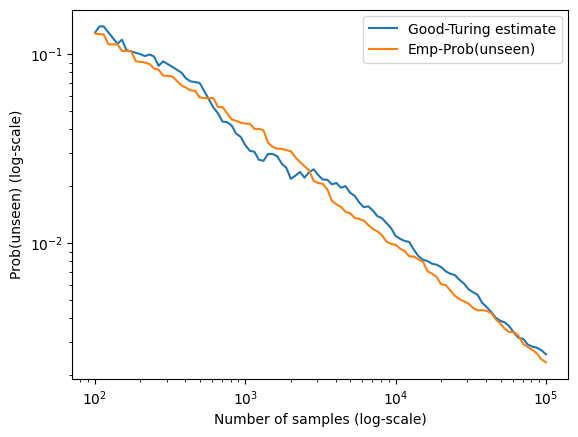

In [23]:
fig, ax = plt.subplots()
ax.plot(xs, es, label="Good-Turing estimate")
ax.plot(xs, ps, label="Emp-Prob(unseen)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Number of samples (log-scale)")
ax.set_ylabel("Prob(unseen) (log-scale)")
ax.legend()
plt.show()

***💡 Go back to the slides :)***

# **Species Richness**: What is the maximum coverage we can achieve?

## Chao estimator

The estimate of the lower bound of the remaining coverage is
$$
\frac{n - 1}{n}\frac{(\Phi_1)^2}{2\Phi_2}
$$

In [ ]:
n = 50000
population = []
for i in range(n):
    population.append(fuzzer.fuzz())

#################################################################
# Get the number of singletons and doubletons after sampling
# curr_coverage: a set of unique coverage hashes found from the population
# num_singletons: the number of coverage hashes that are seen exactly once
# num_doubletons: the number of coverage hashes that are seen exactly twice
#################################################################
curr_coverage = set()
for inp in population:
    pass # IMPLEMENT HERE!
num_singletons = -1
num_doubletons = -1
#################################################################

print(f"[        Found] The number of unique colors found so far is {len(curr_coverage)}")
print(
    "[    Singleton] The number of color seen exactly once is "
    + str(num_singletons)
)
print(
    "[    Doubleton] The number of color seen exactly twice is "
    + str(num_doubletons)
)

############# Chao estimator #############
estimate = -1  # IMPLEMENT HERE!
##########################################

print(
    f"[Chao Estimate] The lower bound of the number of coverages that are still unexplored is estimated by {estimate}."
)

## How do we evaluate this?

### Again, evaluate the estimator empirically

Let's try to run the fuzzer **much longer** and see if we can reach the Chao estimate.

In [ ]:
######### Empirical Evaluation ##########
multiplier = 5
extra_trials = n * multiplier
validation = []
for i in range(extra_trials):
    validation.append(fuzzer.fuzz())

################################################################################
# extra_coverage: a set of unique coverage hashes found from the validation set
#                 but not in the previously observed coverage
################################################################################
extra_coverage = set()
for idx, inp in enumerate(validation, 1):
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    cov_hash = getCovHash(cov)
    pass  # IMPLEMENT extra_coverage using curr_coverage!
    if idx % (n / 2) == 0:
        num_new_coverage = len(extra_coverage)
        print(f"After {idx} more samples, {num_new_coverage} new coverages are found.")
##########################################

***💡 Go back to the slides***

# **Extrapolation**: How much can I discover more when I spend $X$ more time here?

- $\Delta(m)$: the number of new discoveries when $m$ more samples are retrieved.

$$
\hat \Delta(m) = \hat \Phi_0 \left[1 - \left(1 - \frac{\Phi_1}{n\hat \Phi_0 + \Phi_1} \right)^m\right]
$$

## What I'm going to do:

### 1. **Initial sample of size 200,000:** Check the coverage incrase & Count the number of **singletons** ($\Phi_1$) and **doubletons** ($\Phi_2$).
### 2. **Extrapolation:** Estimate how the coverage discovery will increase for the **next 200,000 samples** with the estimator above.
### 3. **Comparison with the empirical result:** Actually getting 200,000 samples more and see how the coverage discovery empirically increases.


In [ ]:
# First 200,000 inputs => Initial sample data
n = 200000
population = []
for i in range(n):
    population.append(fuzzer.fuzz())

############################################################
# cumulative_coverage: list of cumulative number of unique coverages (len = n)
# num_singletons: the number singletons in the first 200,000 inputs
# num_doubletons: the number doubletons in the first 200,000 inputs
# num_singletons and num_doubletons are used for extrapolation
############################################################
cumulative_coverage = []
all_coverage = set()
singletons = set()  # Store the number of singletons 
doubletons = set()  # and doubletons for the extrapolation

for inp in tqdm(population):
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    this_coverage = set([getCovHash(cov)])
    doubletons -= this_coverage
    doubletons |= singletons & this_coverage
    singletons -= this_coverage
    singletons |= this_coverage - all_coverage
    all_coverage |= this_coverage
    cumulative_coverage.append(len(all_coverage))

# Number of singletons and doubletons from the first 200,000 inputs
# => Used for extrapolation
num_singletons = len(singletons)
num_doubletons = len(doubletons)

############################################################
# Additional 200,000 inputs => Validation data (not used for extrapolation)
# Append the cumulative number of unique coverages found from the validation 
# data to cumulative_coverage (len: n -> n + extra_n)
############################################################
extra_n = 200000
validation = []
for i in range(extra_n):
    validation.append(fuzzer.fuzz())

for inp in tqdm(validation):
    with Coverage() as cov:
        try:
            my_parser(inp)
        except BaseException:
            pass
    cov_hash = getCovHash(cov)
    all_coverage.add(cov_hash)
    cumulative_coverage.append(len(all_coverage))
############################################################


### **1) How the coverage increases with the first 200,000 samples**

In [ ]:
fig, ax = plt.subplots()
coverage_ateach_1000trial = [0] + cumulative_coverage[
    999::1000
]  # for every 1000 trials
 # the first half of cumulative_coverage (until n = 100,000)
sub_coverage_until_half = coverage_ateach_1000trial[:201]
sns.lineplot(
    x=range(0, n + 1, 1000),
    y=sub_coverage_until_half,
    ax=ax,
)
ax.set_xlim(0, 2 * n)
ax.set_ylim(0, cumulative_coverage[-1])
ax.set_xticks([0, n / 2, n, n * 3 / 2, 2 * n])
ax.set_xlabel("Number of inputs")
ax.set_ylabel("Number of unique coverages")
ax.set_title("Coverage growth over time (200,000 inputs)")
plt.show()

### **2) Extrapolation of the coverage increase for the next 200,000 samples**

$$
\hat \Delta(m) = \hat \Phi_0 \left[1 - \left(1 - \frac{\Phi_1}{n\hat \Phi_0 + \Phi_1} \right)^m\right],
$$
where
$$
\hat \Phi_0 = \text{Chao estimator} = \frac{n - 1}{n}\frac{(\Phi_1)^2}{2\Phi_2}
$$

In [ ]:
############################ Extrapolation ##############################
# extrapolator: function to extrapolate the number of unique coverages
#               after m additional inputs
# extrapolated: list of extrapolated number of unique coverages after n inputs
# (len: n)      and up to 2n inputs; will be compared with the validation data,
#               i.e., the second half of cumulative_coverage
########################################################################
extrapolator = lambda m: -1 # IMPLEMENT HERE!

extrapolated = [extrapolator(i) for i in range(1, n + 1)]
extrapolated = [delta + sub_coverage_until_half[-1] for delta in extrapolated]
########################################################################

fig, ax = plt.subplots()
sns.lineplot(
    x=range(0, n + 1, 1000),
    y=sub_coverage_until_half,
    ax=ax,
    color="black",
)
sns.lineplot(
    x=range(n + 1000, n * 2 + 1, 1000),
    y=extrapolated[999::1000],
    ax=ax,
    color="blue",
    dashes=True,
)
ax.set_xlabel("Number of inputs")
ax.set_ylabel("Number of unique coverages")
ax.set_title("Coverage growth over time (blue: extrapolated)")

plt.show()

### **3) Comparison: Extrapolate vs. How the coverage increases empirically with the next 200,000 samples**

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(
    x=range(0, n + 1, 1000),
    y=sub_coverage_until_half,
    ax=ax,
    color="black",
)
sns.lineplot(
    x=range(n + 1000, n * 2 + 1, 1000),
    y=extrapolated[999::1000],
    ax=ax,
    color="blue",
    dashes=True,
)
sns.lineplot(
    x=range(n + 1000, n * 2 + 1, 1000),
    y=coverage_ateach_1000trial[201:],
    ax=ax,
    color="red",
)
ax.set_xlabel("Number of inputs")
ax.set_ylabel("Number of unique coverages")
ax.set_title("Coverage growth over time (blue: extrapolated, red: validation)")
plt.show()

***💡 Go back to the slides***